In [1]:
%load_ext autoreload
%autoreload 1
%aimport mllib.helpers, mllib.loaders, mllib.plotters

Using TensorFlow backend.


In [2]:
# This helps with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [3]:
from collections import defaultdict
from pprint import pprint
from time import time
import warnings

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, kurtosis
import seaborn as sns; sns.set()
from sklearn.cluster import KMeans
from sklearn.decomposition import FastICA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import SparseRandomProjection

from mllib.loaders import load_adult, load_mnist
from mllib.helpers import balanced_accuracy, cluster_acc, save_cluster_result, load_cluster_result

In [4]:
dataset = 'mnist'
learner_type = 'ANN'
loader_func = load_mnist

In [5]:
df = loader_func(preprocess=True)

Target column encoded with the following classes [4. 9.]
Dataset shape (13782, 785)
Value composition:
1    0.504861
0    0.495139
Name: target, dtype: float64


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/wessm/OMSCS/ML/a3/mllib/loaders.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_df['target'] = le.fit_transform(filtered_df['target'])


In [6]:
X = df.drop('target', axis=1)
X = X / 255
y = df['target']
n_samples, n_features = X.shape
print(n_samples, n_features)

13782 784


# Clustering (à la carte)

## K-Means

In [86]:
n_clusters = np.hstack((
    np.arange(2, 10),
    np.arange(10, 21, 2),
    np.array([50]),
    np.arange(100, 501, 200),
#     np.array([n_samples/2, n_samples], dtype=np.int)
)).astype(np.int)
print(n_clusters)

[  2   3   4   5   6   7   8   9  10  12  14  16  18  20  50 100 300 500]


In [155]:
km_res = defaultdict(dict)
for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
                n_jobs=-1,
               )
    t0 = time()
    km.fit(X)
    t = time() - t0
    y_km = km.predict(X)
    km_res[k]['dist'] = km.inertia_
    km_res[k]['time'] = t
    km_res[k]['sil'] = silhouette_score(X, y_km, random_state=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, t))

done k=2 in 4.114 sec
done k=3 in 7.414 sec
done k=4 in 9.267 sec
done k=5 in 11.504 sec
done k=6 in 14.763 sec
done k=7 in 15.095 sec
done k=8 in 17.810 sec
done k=9 in 18.224 sec
done k=10 in 20.271 sec
done k=12 in 24.113 sec
done k=14 in 22.877 sec
done k=16 in 24.470 sec
done k=18 in 26.778 sec
done k=20 in 29.318 sec
done k=50 in 49.313 sec
done k=100 in 66.559 sec
done k=300 in 143.347 sec
done k=500 in 196.383 sec


In [156]:
save_cluster_result(em_res, dataset, 'km')

In [24]:
km_res = load_cluster_result(dataset, 'km')

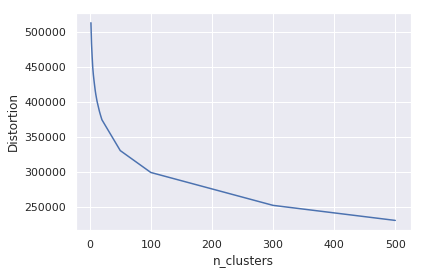

In [157]:
plt.plot(n_clusters, [km_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

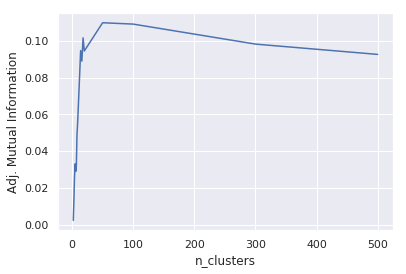

In [29]:
plt.plot(n_clusters, [km_res[k]['ami'] for k in n_clusters])
# plt.semilogx()
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.show()

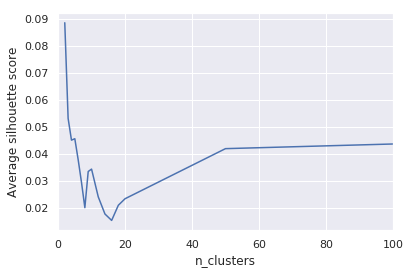

In [27]:
plt.plot(n_clusters, [km_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhouette score')
plt.xlim([0, 100])
plt.show()

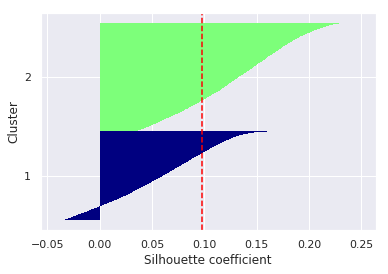

In [165]:
km = KMeans(n_clusters=2,
                random_state=0,
                n_jobs=-1,
               )
y_km = km.fit_predict(X)
cluster_labels = np.unique(y_km)
m_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0,0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / m_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

In [22]:
km2 = KMeans(n_clusters=2,
                random_state=0,
                n_jobs=-1,
               )
y_km = km2.fit_predict(X)
balanced_accuracy(pred=y_km, truth=y)

0.5261552146575652

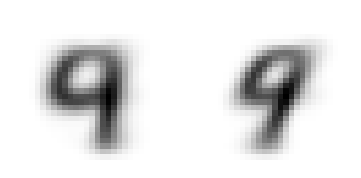

In [23]:
fig, ax = plt.subplots(1, 2)
centers = km2.cluster_centers_.reshape(2, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

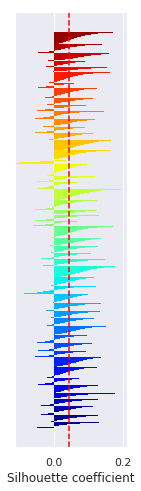

In [131]:
km = KMeans(n_clusters=50,
                random_state=0,
                n_jobs=-1,
               )

y_km = km.fit_predict(X)
plt.subplots(figsize=(2,8))
cluster_labels = np.unique(y_km)
m_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0,0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / m_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--") 
plt.yticks([])
# plt.ylabel('Cluster')
plt.xlim([-0.11, 0.21])
plt.xlabel('Silhouette coefficient')
plt.show()

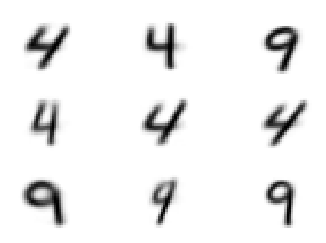

In [135]:
fig, ax = plt.subplots(3, 3)
centers = km.cluster_centers_.reshape(50, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# Expectation Maximization

In [30]:
em_res = defaultdict(dict)
for k in n_clusters:
    gm = GaussianMixture(
        n_components=k,
        random_state=0,
#         n_jobs=-1, # Not supported for GMM?
        n_init=1,
        init_params='kmeans',
#         max_iter=600,
    )
    t0 = time()
    gm.fit(X)
    t = time() - t0
    y_gm = gm.predict(X)
    em_res[k]['bic'] = gm.bic(X)
    em_res[k]['aic'] = gm.aic(X)
    em_res[k]['ll'] = gm.score(X)
    em_res[k]['time'] = t
    em_res[k]['sil'] = silhouette_score(X, y_gm, random_state=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        em_res[k]['ami'] = ami(y, y_gm)
    print('done k=%i in %.3f sec' % (k, t))

done k=2 in 48.146 sec
done k=3 in 138.697 sec
done k=4 in 61.432 sec
done k=5 in 96.477 sec
done k=6 in 84.008 sec
done k=7 in 199.005 sec
done k=8 in 164.429 sec
done k=9 in 103.679 sec
done k=10 in 131.160 sec
done k=12 in 198.314 sec
done k=14 in 249.669 sec
done k=16 in 240.488 sec
done k=18 in 227.773 sec
done k=20 in 337.644 sec
done k=50 in 95.229 sec
done k=100 in 110.448 sec
done k=300 in 335.045 sec
done k=500 in 528.092 sec


In [31]:
save_cluster_result(em_res, dataset, 'em')

In [32]:
# em_res = load_cluster_result(dataset, 'em')

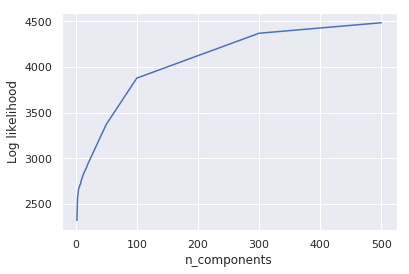

In [33]:
plt.plot(n_clusters, [em_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

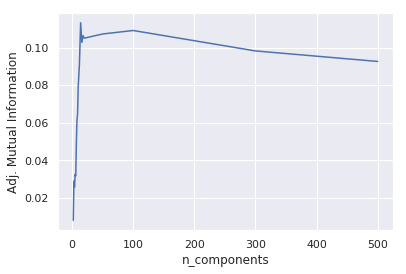

In [34]:
plt.plot(n_clusters, [em_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Adj. Mutual Information')
plt.show()

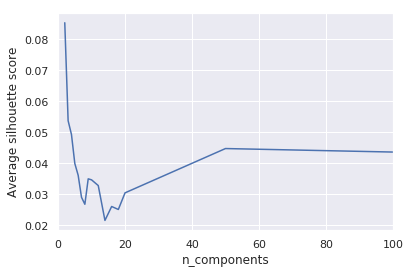

In [37]:
plt.plot(n_clusters, [em_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.xlim([0,100])
plt.show()

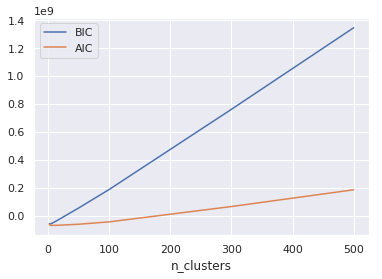

In [36]:
plt.plot(n_clusters, [em_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

# Dimensionality Reduction (à la carte)

## PCA

In [167]:
pca = PCA(
    n_components=None,
    random_state=0,
)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

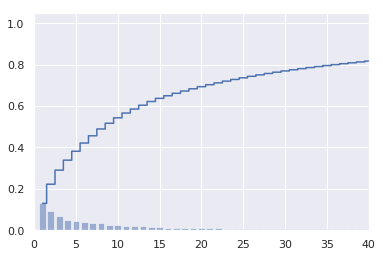

In [171]:
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 40])
plt.show()

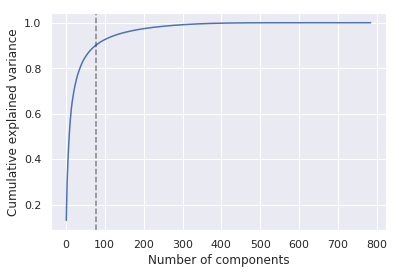

In [208]:
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
plt.axvline(77, linestyle='--', color='k', alpha=0.5)

In [14]:
np.cumsum(pca.explained_variance_ratio_)[59]

NameError: name 'pca' is not defined

In [209]:
pca = PCA(
    n_components=77,
    random_state=0,
)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=77, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

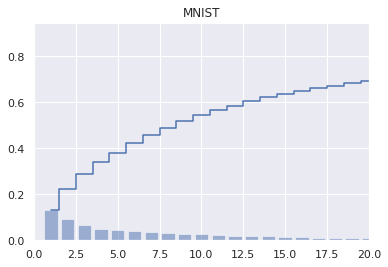

In [212]:
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 20])
plt.title('MNIST')
plt.show()

## ICA

In [179]:
ica = FastICA(
    n_components=10,
    random_state=0,
    max_iter=400,
)
X_tr = ica.fit_transform(X)
kurt_df = pd.DataFrame(kurtosis(X_tr, axis=0), columns=['kurtosis'])
# kurt_df = kurt_df.abs()
kurt_df.sort_values(by='kurtosis', ascending=False)

,kurtosis
8,1.634690
0,0.538558
1,-0.536100
6,-0.660727
3,-0.739701
7,-0.957393
4,-1.040876
9,-1.113972
5,-1.129330
2,-1.186912


In [15]:
component_counts = np.hstack((
    np.arange(1, 10),
    np.arange(10, 21, 2),
    np.array([30, 40, 50, 60, 80]),
    np.arange(100, 501, 100),
)).astype(np.int)
total_kurtosis = {}

for component_count in component_counts:
    tmp_ica = FastICA(
        random_state=0,
        n_components=component_count,
    )
    tmp_X_tr = tmp_ica.fit_transform(X)
    total_kurtosis[component_count] = np.abs(kurtosis(tmp_X_tr, axis=0)).sum()

pprint(total_kurtosis)

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/d

{1: 0.8215746806373261,
 2: 1.7534943562133611,
 3: 2.435570163087947,
 4: 3.396231840862894,
 5: 4.092883167507894,
 6: 4.618448814905887,
 7: 5.954431429456823,
 8: 7.1269134131929945,
 9: 8.405913324251761,
 10: 9.538259438821004,
 12: 14.144038750585008,
 14: 16.069893423386006,
 16: 20.137164395819845,
 18: 26.454813645096856,
 20: 36.10461867370296,
 30: 73.83830887992706,
 40: 127.87497031454961,
 50: 205.6807384683962,
 60: 280.1368059630538,
 80: 452.18190475104734,
 100: 649.8956558463304,
 200: 2147.7120514054814,
 300: 4734.1363298863525,
 400: 12554.150560709051,
 500: 78588.5733620969}


[]

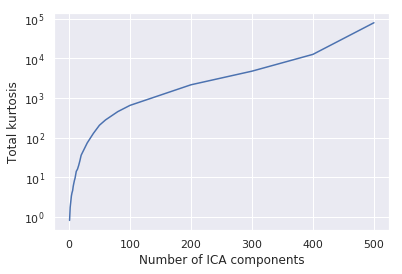

In [16]:
pd.Series(total_kurtosis).plot()
plt.ylabel('Total kurtosis')
plt.xlabel('Number of ICA components')
plt.semilogy()

In [187]:
ica100 = FastICA(
    random_state=0,
    n_components=100,
)
X_tr100 = ica100.fit_transform(X)
kurt_df100 = pd.DataFrame(kurtosis(X_tr100, axis=0), columns=['kurtosis'])
kurt_df100.sort_values(by='kurtosis', ascending=False).iloc[0]

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


kurtosis    37.414005
Name: 19, dtype: float64

In [196]:
kurt_df100.sort_values(by='kurtosis', ascending=False).iloc[:6]

,kurtosis
19,37.414005
76,30.697088
89,29.707276
25,27.897810
32,24.560057
68,22.243987


In [190]:
X_tr100[19, :].shape

(100,)

In [191]:
ica100.components_.shape

(100, 784)

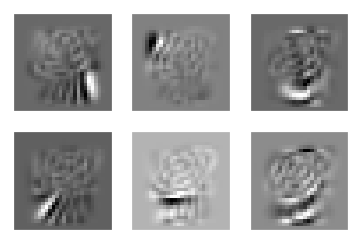

In [197]:
fig, ax = plt.subplots(2, 3)
components = [
    ica100.components_[19].reshape(28, 28),
    ica100.components_[76].reshape(28, 28),
    ica100.components_[89].reshape(28, 28),
    ica100.components_[25].reshape(28, 28),
    ica100.components_[32].reshape(28, 28),
    ica100.components_[68].reshape(28, 28),
]
for axi, component in zip(ax.flat, components):
    axi.set(xticks=[], yticks=[])
    axi.imshow(component, interpolation='nearest', cmap=plt.cm.binary)

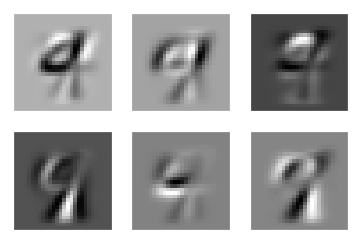

In [199]:
ica6 = FastICA(
    random_state=0,
    n_components=6,
)
ica6.fit(X)
components = ica6.components_.reshape(6, 28, 28)
fig, ax = plt.subplots(2, 3)
for axi, component in zip(ax.flat, components):
    axi.set(xticks=[], yticks=[])
    axi.imshow(component, interpolation='nearest', cmap=plt.cm.binary)

# Dimensionality reduction and clustering

## PCA

In [18]:
component_counts = [50, 100]
pca_km_results = {}

for cc in component_counts:
    tmp_pca = PCA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_pca.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            n_jobs=-1,
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    pca_km_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset,'km', 'pca%i' % cc)

Doing 50 components
done k=2 in 0.422 sec
done k=3 in 0.889 sec
done k=4 in 1.167 sec
done k=5 in 1.035 sec
done k=6 in 2.094 sec
done k=7 in 1.442 sec
done k=8 in 1.698 sec
done k=9 in 2.734 sec
done k=10 in 2.677 sec
done k=12 in 2.543 sec
done k=14 in 3.183 sec
done k=16 in 3.547 sec
done k=18 in 3.509 sec
done k=20 in 3.471 sec
done k=50 in 7.234 sec
done k=100 in 11.915 sec
done k=300 in 23.535 sec
done k=500 in 32.875 sec
Doing 100 components
done k=2 in 0.632 sec
done k=3 in 1.108 sec
done k=4 in 1.783 sec
done k=5 in 1.855 sec
done k=6 in 2.708 sec
done k=7 in 3.349 sec
done k=8 in 2.862 sec
done k=9 in 3.387 sec
done k=10 in 3.680 sec
done k=12 in 3.943 sec
done k=14 in 4.158 sec
done k=16 in 3.871 sec
done k=18 in 5.136 sec
done k=20 in 4.452 sec
done k=50 in 9.456 sec
done k=100 in 14.079 sec
done k=300 in 29.636 sec
done k=500 in 41.825 sec


In [69]:
pca_gm_results = {}
component_counts = [1, 2, 50, 75, 100]
for cc in component_counts:
    tmp_pca = PCA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_pca.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    pca_gm_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset, 'em', 'pca%i' % cc)

Doing 1 components
done k=2 in 0.023 sec
done k=3 in 0.039 sec
done k=4 in 0.050 sec
done k=5 in 0.075 sec
done k=6 in 0.097 sec
done k=7 in 0.083 sec
done k=8 in 0.126 sec
done k=9 in 0.114 sec
done k=10 in 0.114 sec
done k=12 in 0.166 sec
done k=14 in 0.196 sec
done k=16 in 0.204 sec
done k=18 in 0.250 sec
done k=20 in 0.231 sec
done k=30 in 0.321 sec
done k=40 in 0.451 sec
done k=50 in 0.547 sec
done k=60 in 0.672 sec
done k=80 in 0.852 sec
Doing 2 components
done k=2 in 0.038 sec
done k=3 in 0.049 sec
done k=4 in 0.075 sec
done k=5 in 0.146 sec
done k=6 in 0.153 sec
done k=7 in 0.155 sec
done k=8 in 0.230 sec
done k=9 in 0.182 sec
done k=10 in 0.349 sec
done k=12 in 0.314 sec
done k=14 in 0.257 sec
done k=16 in 0.465 sec
done k=18 in 0.598 sec
done k=20 in 0.547 sec
done k=30 in 0.974 sec
done k=40 in 1.253 sec
done k=50 in 1.524 sec
done k=60 in 1.592 sec
done k=80 in 1.979 sec
Doing 50 components
done k=2 in 0.598 sec
done k=3 in 1.722 sec
done k=4 in 5.142 sec
done k=5 in 8.214 

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=12 in 37.338 sec
done k=14 in 31.449 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=16 in 47.424 sec
done k=18 in 50.706 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=20 in 59.931 sec
done k=30 in 50.539 sec
done k=40 in 58.600 sec
done k=50 in 107.240 sec
done k=60 in 98.324 sec
done k=80 in 63.053 sec
Doing 100 components
done k=2 in 3.101 sec
done k=3 in 6.498 sec
done k=4 in 6.749 sec
done k=5 in 18.378 sec
done k=6 in 16.970 sec
done k=7 in 17.674 sec
done k=8 in 28.584 sec
done k=9 in 22.640 sec
done k=10 in 27.158 sec
done k=12 in 32.803 sec
done k=14 in 32.837 sec
done k=16 in 34.715 sec
done k=18 in 55.703 sec
done k=20 in 38.560 sec
done k=30 in 49.419 sec
done k=40 in 59.453 sec
done k=50 in 108.962 sec
done k=60 in 93.432 sec
done k=80 in 68.357 sec


In [38]:
component_counts = [1, 2, 50, 75, 100]
pca_km_results = {cc: load_cluster_result(dataset, 'km', 'pca%i' % cc) for cc in component_counts}
pca_gm_results = {cc: load_cluster_result(dataset, 'em', 'pca%i' % cc) for cc in component_counts}

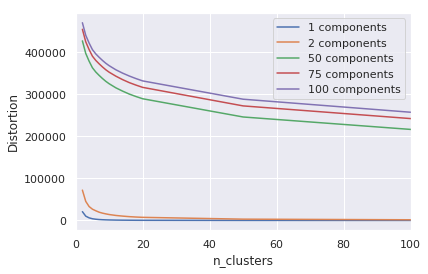

In [39]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.xlim([0,100])
plt.show()

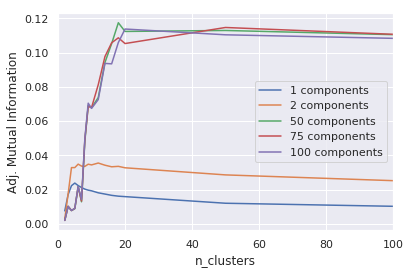

In [40]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

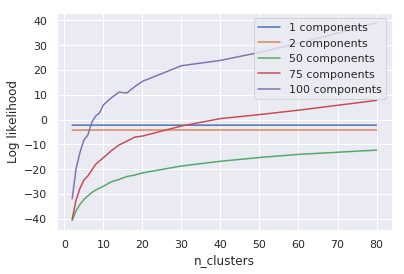

In [70]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.legend(loc='best')
plt.show()

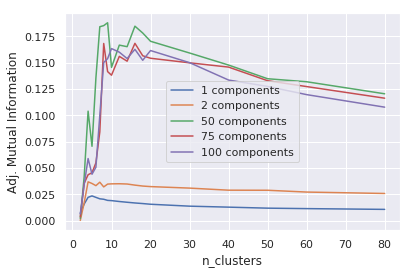

In [93]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

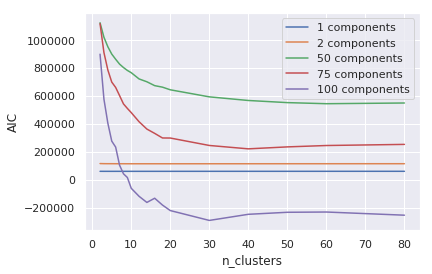

In [72]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

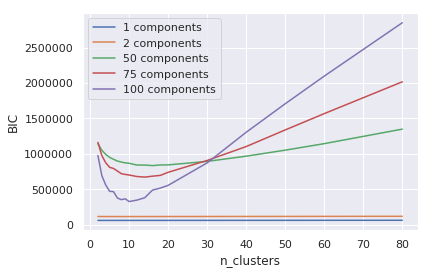

In [73]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()

## ICA

In [20]:
component_counts = [1, 2, 50, 75, 100]
ica_km_results = {}

for cc in component_counts:
    tmp_dr = FastICA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            n_jobs=-1,
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    ica_km_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset,'km', 'ica%i' % cc)

Doing 1 components
done k=2 in 0.063 sec
done k=3 in 0.113 sec
done k=4 in 0.173 sec
done k=5 in 0.229 sec
done k=6 in 0.302 sec
done k=7 in 0.313 sec
done k=8 in 0.291 sec
done k=9 in 0.457 sec
done k=10 in 0.372 sec
done k=12 in 0.561 sec
done k=14 in 0.587 sec
done k=16 in 0.481 sec
done k=18 in 0.605 sec
done k=20 in 0.749 sec
done k=50 in 1.264 sec
done k=100 in 2.345 sec
done k=300 in 5.610 sec
done k=500 in 9.043 sec
Doing 2 components
done k=2 in 0.109 sec
done k=3 in 0.167 sec
done k=4 in 0.199 sec
done k=5 in 0.336 sec
done k=6 in 0.471 sec
done k=7 in 0.386 sec
done k=8 in 0.607 sec
done k=9 in 0.870 sec
done k=10 in 0.998 sec
done k=12 in 1.082 sec
done k=14 in 1.437 sec
done k=16 in 1.925 sec
done k=18 in 1.449 sec
done k=20 in 1.864 sec
done k=50 in 3.944 sec
done k=100 in 7.237 sec
done k=300 in 13.930 sec
done k=500 in 18.198 sec
Doing 50 components
done k=2 in 1.106 sec
done k=3 in 1.250 sec
done k=4 in 1.792 sec
done k=5 in 2.217 sec
done k=6 in 2.273 sec
done k=7 in 

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Doing 100 components
done k=2 in 2.337 sec
done k=3 in 2.907 sec
done k=4 in 3.126 sec
done k=5 in 3.413 sec
done k=6 in 3.905 sec
done k=7 in 3.325 sec
done k=8 in 4.215 sec
done k=9 in 4.138 sec
done k=10 in 5.372 sec
done k=12 in 4.485 sec
done k=14 in 6.475 sec
done k=16 in 5.693 sec
done k=18 in 7.998 sec
done k=20 in 7.449 sec
done k=50 in 10.971 sec
done k=100 in 17.087 sec
done k=300 in 32.195 sec
done k=500 in 48.322 sec


In [21]:
ica_gm_results = {}

for cc in component_counts:
    tmp_dr = FastICA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    ica_gm_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset, 'em', 'ica%i' % cc)

Doing 1 components
done k=2 in 0.020 sec
done k=3 in 0.029 sec
done k=4 in 0.043 sec
done k=5 in 0.072 sec
done k=6 in 0.049 sec
done k=7 in 0.056 sec
done k=8 in 0.063 sec
done k=9 in 0.059 sec
done k=10 in 0.055 sec
done k=12 in 0.085 sec
done k=14 in 0.087 sec
done k=16 in 0.094 sec
done k=18 in 0.127 sec
done k=20 in 0.114 sec
done k=50 in 0.225 sec
done k=100 in 0.416 sec
done k=300 in 1.159 sec
done k=500 in 2.042 sec
Doing 2 components
done k=2 in 0.026 sec
done k=3 in 0.037 sec
done k=4 in 0.048 sec
done k=5 in 0.087 sec
done k=6 in 0.121 sec
done k=7 in 0.090 sec
done k=8 in 0.100 sec
done k=9 in 0.172 sec
done k=10 in 0.163 sec
done k=12 in 0.182 sec
done k=14 in 0.171 sec
done k=16 in 0.337 sec
done k=18 in 0.271 sec
done k=20 in 0.273 sec
done k=50 in 0.561 sec
done k=100 in 1.611 sec
done k=300 in 3.145 sec
done k=500 in 5.040 sec
Doing 50 components
done k=2 in 0.725 sec
done k=3 in 1.342 sec
done k=4 in 2.844 sec
done k=5 in 1.297 sec
done k=6 in 4.101 sec
done k=7 in 4.

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=3 in 7.090 sec
done k=4 in 4.862 sec
done k=5 in 6.986 sec
done k=6 in 9.758 sec
done k=7 in 6.626 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=8 in 18.894 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=9 in 22.392 sec
done k=10 in 19.222 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=12 in 29.860 sec
done k=14 in 19.299 sec
done k=16 in 32.734 sec
done k=18 in 28.663 sec
done k=20 in 23.870 sec
done k=50 in 49.862 sec
done k=100 in 98.099 sec
done k=300 in 21.178 sec
done k=500 in 31.852 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Doing 100 components
done k=2 in 3.669 sec
done k=3 in 5.078 sec
done k=4 in 4.473 sec
done k=5 in 8.593 sec
done k=6 in 16.130 sec
done k=7 in 16.908 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=8 in 26.004 sec
done k=9 in 18.479 sec
done k=10 in 25.239 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=12 in 42.200 sec
done k=14 in 34.286 sec
done k=16 in 33.939 sec
done k=18 in 55.091 sec
done k=20 in 66.811 sec
done k=50 in 126.035 sec
done k=100 in 110.391 sec
done k=300 in 28.022 sec
done k=500 in 47.576 sec


In [76]:
component_counts = [1, 2, 50, 75, 100]
ica_km_results = {cc: load_cluster_result(dataset, 'km', 'ica%i' % cc) for cc in component_counts}
ica_gm_results = {cc: load_cluster_result(dataset, 'em', 'ica%i' % cc) for cc in component_counts}

In [84]:
ica_km_results[100][2].keys()

dict_keys(['dist', 'time', 'sil', 'ami'])

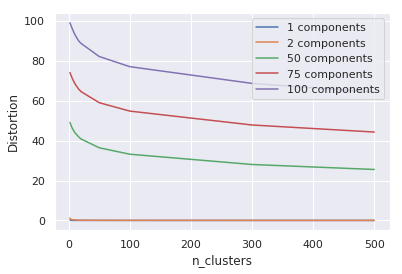

In [87]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)
    
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='upper right')
plt.show()

In [97]:
n_clusters = np.hstack((
    np.arange(2, 10),
    np.arange(10, 21, 2),
    np.array([30, 40, 50, 60, 80]),
#     np.array([n_samples/2, n_samples], dtype=np.int)
)).astype(np.int)
component_counts = [1, 2, 50, 75, 100]
for cc in component_counts:
    plt.plot(n_clusters, [ica_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0,100])
plt.legend(loc='best')
plt.show()

KeyError: 'ami'

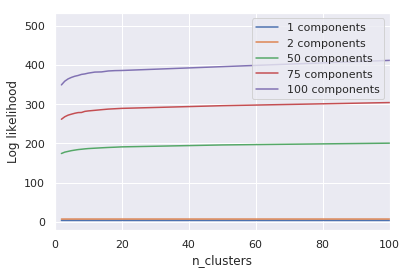

In [47]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

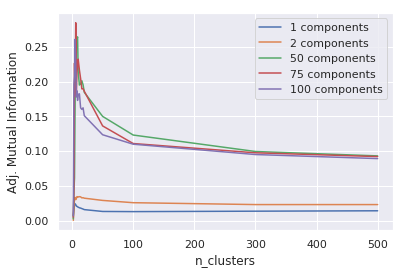

In [48]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

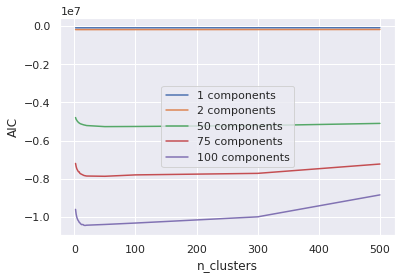

In [49]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

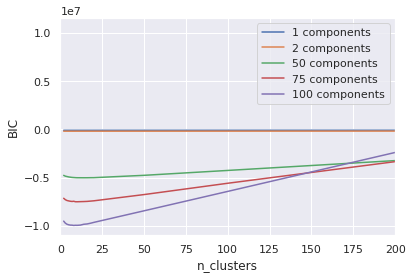

In [52]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.xlim([0,200])
plt.show()

## RP

In [53]:
n_clusters = np.hstack((
    np.arange(2, 10),
    np.arange(10, 21, 2),
    np.array([30, 40, 50, 60, 80]),
#     np.array([n_samples/2, n_samples], dtype=np.int)
)).astype(np.int)
rp_km_results = {}

for cc in component_counts:
    tmp_dr = SparseRandomProjection(n_components=cc, random_state=0, eps=None)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            n_jobs=-1,
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    rp_km_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset,'km', 'rp%i' % cc)

Doing 1 components
done k=2 in 0.202 sec
done k=3 in 0.171 sec
done k=4 in 0.324 sec
done k=5 in 0.341 sec
done k=6 in 0.341 sec
done k=7 in 0.320 sec
done k=8 in 0.367 sec
done k=9 in 0.546 sec
done k=10 in 0.440 sec
done k=12 in 0.375 sec
done k=14 in 0.441 sec
done k=16 in 0.513 sec
done k=18 in 0.545 sec
done k=20 in 0.557 sec
done k=30 in 0.739 sec
done k=40 in 1.172 sec
done k=50 in 1.207 sec
done k=60 in 1.454 sec
done k=80 in 1.879 sec
Doing 2 components
done k=2 in 0.313 sec
done k=3 in 0.227 sec
done k=4 in 0.637 sec
done k=5 in 0.729 sec
done k=6 in 0.466 sec
done k=7 in 1.251 sec
done k=8 in 0.933 sec
done k=9 in 1.165 sec
done k=10 in 1.619 sec
done k=12 in 1.538 sec
done k=14 in 1.804 sec
done k=16 in 2.049 sec
done k=18 in 2.982 sec
done k=20 in 2.882 sec
done k=30 in 4.266 sec
done k=40 in 3.954 sec
done k=50 in 5.168 sec
done k=60 in 5.606 sec
done k=80 in 7.215 sec
Doing 50 components
done k=2 in 0.358 sec
done k=3 in 0.783 sec
done k=4 in 0.937 sec
done k=5 in 1.337 

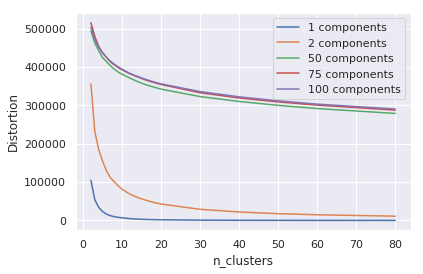

In [54]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.show()

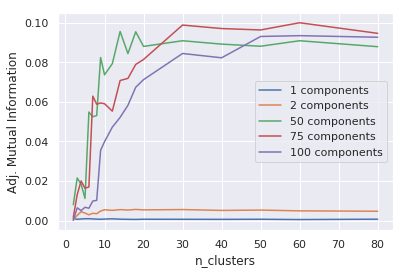

In [55]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

In [56]:
rp_gm_results = {}

for cc in component_counts:
    tmp_dr = SparseRandomProjection(n_components=cc, random_state=0, eps=None)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    rp_gm_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset, 'em', 'rp%i' % cc)

Doing 1 components
done k=2 in 0.034 sec
done k=3 in 0.057 sec
done k=4 in 0.086 sec
done k=5 in 0.090 sec
done k=6 in 0.093 sec
done k=7 in 0.101 sec
done k=8 in 0.084 sec
done k=9 in 0.122 sec
done k=10 in 0.114 sec
done k=12 in 0.127 sec
done k=14 in 0.162 sec
done k=16 in 0.142 sec
done k=18 in 0.195 sec
done k=20 in 0.224 sec
done k=30 in 0.362 sec
done k=40 in 0.434 sec
done k=50 in 1.266 sec
done k=60 in 1.692 sec
done k=80 in 1.994 sec
Doing 2 components
done k=2 in 0.069 sec
done k=3 in 0.091 sec
done k=4 in 0.125 sec
done k=5 in 0.150 sec
done k=6 in 0.188 sec
done k=7 in 0.240 sec
done k=8 in 0.203 sec
done k=9 in 0.218 sec
done k=10 in 0.375 sec
done k=12 in 0.284 sec
done k=14 in 0.341 sec
done k=16 in 0.401 sec
done k=18 in 0.633 sec
done k=20 in 0.581 sec
done k=30 in 0.680 sec
done k=40 in 0.900 sec
done k=50 in 1.109 sec
done k=60 in 1.272 sec
done k=80 in 1.672 sec
Doing 50 components
done k=2 in 0.410 sec
done k=3 in 1.154 sec
done k=4 in 3.385 sec
done k=5 in 6.968 

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=6 in 8.814 sec
done k=7 in 5.266 sec
done k=8 in 4.389 sec
done k=9 in 7.389 sec
done k=10 in 8.502 sec
done k=12 in 10.195 sec
done k=14 in 12.016 sec
done k=16 in 16.970 sec
done k=18 in 24.317 sec
done k=20 in 24.013 sec
done k=30 in 28.869 sec
done k=40 in 40.018 sec
done k=50 in 31.381 sec
done k=60 in 50.433 sec
done k=80 in 46.717 sec
Doing 75 components
done k=2 in 1.005 sec
done k=3 in 1.951 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=4 in 11.008 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=5 in 13.687 sec
done k=6 in 9.958 sec
done k=7 in 9.701 sec
done k=8 in 18.763 sec
done k=9 in 12.381 sec
done k=10 in 18.605 sec
done k=12 in 26.749 sec
done k=14 in 25.327 sec
done k=16 in 40.087 sec
done k=18 in 28.259 sec
done k=20 in 31.666 sec
done k=30 in 44.096 sec
done k=40 in 54.116 sec
done k=50 in 40.992 sec
done k=60 in 71.105 sec
done k=80 in 44.758 sec
Doing 100 components
done k=2 in 5.622 sec
done k=3 in 2.545 sec
done k=4 in 11.241 sec
done k=5 in 7.963 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done k=6 in 22.038 sec
done k=7 in 21.578 sec
done k=8 in 20.729 sec
done k=9 in 30.181 sec
done k=10 in 29.259 sec
done k=12 in 29.110 sec
done k=14 in 19.500 sec
done k=16 in 36.819 sec
done k=18 in 68.127 sec
done k=20 in 43.545 sec
done k=30 in 63.799 sec
done k=40 in 94.111 sec
done k=50 in 56.837 sec
done k=60 in 38.716 sec
done k=80 in 32.630 sec


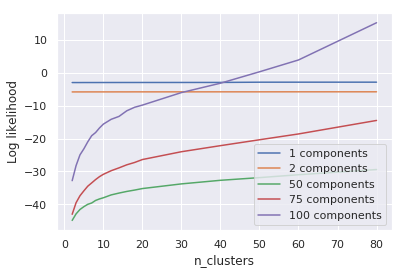

In [91]:
component_counts = [1, 2, 50, 75, 100]
n_clusters = np.hstack((
    np.arange(2, 10),
    np.arange(10, 21, 2),
    np.array([30, 40, 50, 60, 80]),
#     np.array([n_samples/2, n_samples], dtype=np.int)
)).astype(np.int)
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.legend(loc='best')
plt.show()

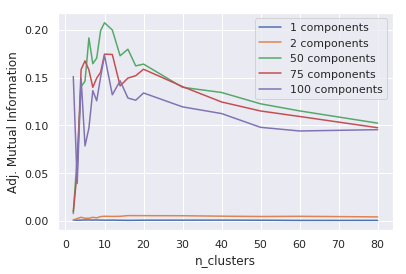

In [58]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

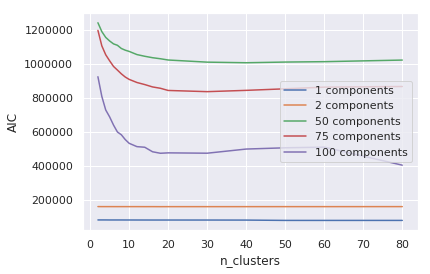

In [59]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

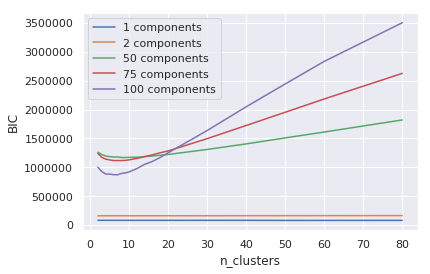

In [60]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()

## LDA

In [61]:
component_counts = [1]
lda_km_results = {}

for cc in component_counts:
    tmp_dr = LDA(n_components=None)
    tmp_X_tr = tmp_dr.fit_transform(X, y)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            n_jobs=-1,
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    lda_km_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset,'km', 'lda%i' % cc)

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Doing 1 components
done k=2 in 0.048 sec
done k=3 in 0.290 sec
done k=4 in 0.197 sec
done k=5 in 0.392 sec
done k=6 in 0.456 sec
done k=7 in 0.388 sec
done k=8 in 0.346 sec
done k=9 in 0.515 sec
done k=10 in 0.476 sec
done k=12 in 0.687 sec
done k=14 in 0.542 sec
done k=16 in 0.603 sec
done k=18 in 0.795 sec
done k=20 in 0.745 sec
done k=30 in 1.055 sec
done k=40 in 1.600 sec
done k=50 in 1.630 sec
done k=60 in 1.456 sec
done k=80 in 2.196 sec


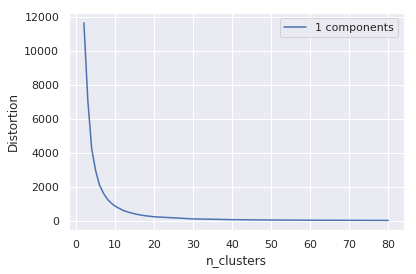

In [62]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.show()

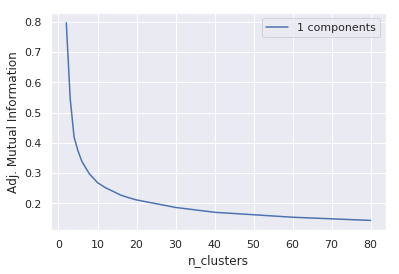

In [63]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

In [64]:
lda_gm_results = {}

for cc in component_counts:
    tmp_dr = LDA(n_components=None)
    tmp_X_tr = tmp_dr.fit_transform(X, y)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    lda_gm_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset, 'em', 'lda%i' % cc)

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Doing 1 components
done k=2 in 0.017 sec
done k=3 in 0.065 sec
done k=4 in 0.082 sec
done k=5 in 0.086 sec
done k=6 in 0.098 sec
done k=7 in 0.110 sec
done k=8 in 0.085 sec
done k=9 in 0.109 sec
done k=10 in 0.118 sec
done k=12 in 0.158 sec
done k=14 in 0.205 sec
done k=16 in 0.163 sec
done k=18 in 0.229 sec
done k=20 in 0.253 sec
done k=30 in 0.271 sec
done k=40 in 0.445 sec
done k=50 in 0.475 sec
done k=60 in 0.622 sec
done k=80 in 0.717 sec


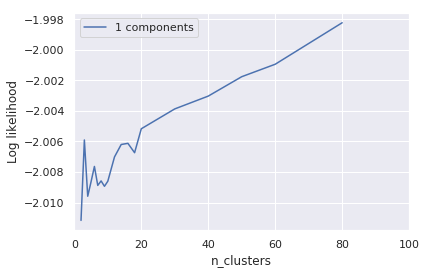

In [65]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

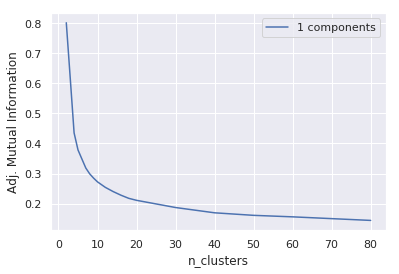

In [66]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

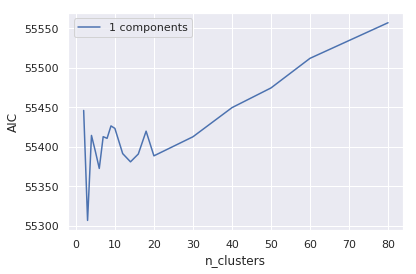

In [67]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

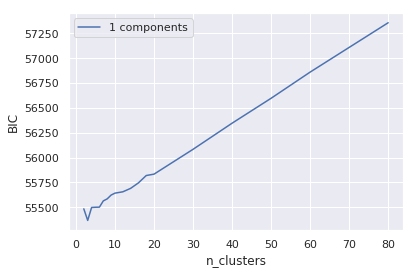

In [68]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()